In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader

# Load dataset
data = pd.read_csv("/content/customers1.csv")
data.head()

class PeopleClassifier(nn.Module):
    def __init__(self, input_size):
        super(PeopleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 4)
    def forward(self, x):
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        x=self.fc4(x)
        return x

data.columns

# Drop ID column as it's not useful for classification
data = data.drop(columns=["ID"])

# Handle missing values
data.fillna({"Work_Experience": 0, "Family_Size": data["Family_Size"].median()}, inplace=True)

# Encode categorical variables
categorical_columns = ["Gender", "Ever_Married", "Graduated", "Profession", "Spending_Score", "Var_1"]
for col in categorical_columns:
    data[col] = LabelEncoder().fit_transform(data[col])

# Encode target variable
label_encoder = LabelEncoder()
data["Segmentation"] = label_encoder.fit_transform(data["Segmentation"])  # A, B, C, D -> 0, 1, 2, 3

# Split features and target
X = data.drop(columns=["Segmentation"])
y = data["Segmentation"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [4]:
# Initialize the Model, Loss Function, and Optimizer
model = PeopleClassifier(input_size=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)

Epoch [10/50], Loss: 1.0100
Epoch [20/50], Loss: 1.1470
Epoch [30/50], Loss: 1.1519
Epoch [40/50], Loss: 1.1672
Epoch [50/50], Loss: 1.0636
Name: HARISHKUMAR R
Register No: 212223230073
Test Accuracy: 48.20%
Confusion Matrix:
 [[226 144  85 129]
 [115 169 132  74]
 [ 71  93 252  56]
 [135  43  31 384]]
Classification Report:
               precision    recall  f1-score   support

           A       0.41      0.39      0.40       584
           B       0.38      0.34      0.36       490
           C       0.50      0.53      0.52       472
           D       0.60      0.65      0.62       593

    accuracy                           0.48      2139
   macro avg       0.47      0.48      0.47      2139
weighted avg       0.48      0.48      0.48      2139



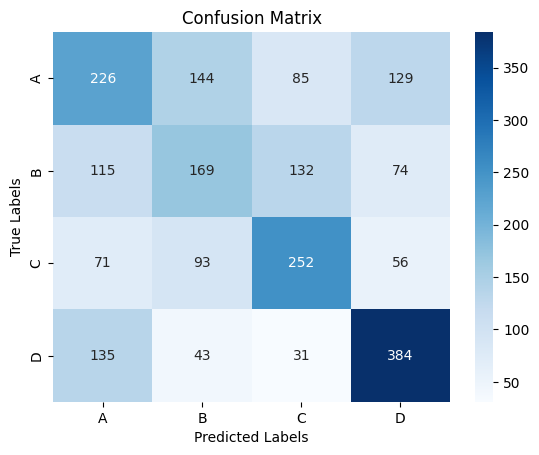

In [11]:

# ---------------- Training ----------------
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

train_model(model, train_loader, criterion, optimizer, epochs=50)

# ---------------- Evaluation ----------------
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)   # pick class index
        predictions.extend(predicted.cpu().numpy())
        actuals.extend(y_batch.cpu().numpy())

# Metrics
accuracy = accuracy_score(actuals, predictions)
conf_matrix = confusion_matrix(actuals, predictions)
class_report = classification_report(
    actuals, predictions, target_names=label_encoder.classes_
)

print("Name: HARISHKUMAR R")
print("Register No: 212223230073")
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Confusion Matrix Plot
sns.heatmap(
    conf_matrix,
    annot=True,
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    fmt="g"
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [12]:
sample_input = X_test[12].clone().unsqueeze(0).detach().type(torch.float32)
with torch.no_grad():
    output = model(sample_input)
    # Select the prediction for the sample (first element)
    predicted_class_index = torch.argmax(output[0]).item()
    predicted_class_label = label_encoder.inverse_transform([predicted_class_index])[0]
print("Name: HARISHKUMAR R")
print("Register No: 212223230073")
print(f'Predicted class for sample input: {predicted_class_label}')
print(f'Actual class for sample input: {label_encoder.inverse_transform([y_test[12].item()])[0]}')

Name: HARISHKUMAR R
Register No: 212223230073
Predicted class for sample input: D
Actual class for sample input: D
